In [1]:
# basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import math
import seaborn as sns
import ast
from collections import Counter
import networkx as nx

# stats imports
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import boxcox
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import pmdarima as pm

# regression imports
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import mixedlm

# src imports
from src.utils import cleaning
#from src.utils import tokenization
from src.utils import filling
from src.utils import cluster_search
from src.data.continents_clusters import regions

# Data loading

In [2]:
# data path
DATA = './src/data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries loading
df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset loading
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

# ratings datasets loading
df_ratings_link = pd.read_csv(DATA + 'ratings_links.csv', sep=',')
df_ratings_ratings = pd.read_csv(DATA + 'ratings_ratings.csv', sep=',')

For now, the plots dataset `df_plots` does not require any cleaning operation, as the dataset presents 0% missing values in its columns with no particular format to standardize. However, the movies and characters dataset do require significant cleaning, as is presented below.

# Movies dataset wrangling

Duplicate movies exist in the movies dataset and are first considered.

In [3]:
# df_movies has duplicates of the same movies which will be discarded based on keeping  
# the entry that has the least number of missing values among the other columns. Only 
# duplicate movies with equal countries are kept
df_movies = cleaning.drop_most_missing(df_movies, ['title', 'countries'])

In [4]:
# doing the same duplicates cleaning as before for df_tmdb, considering 
# 'production_countries' instead of 'countries'
df_tmdb = cleaning.drop_most_missing(df_tmdb, ['title', 'production_countries'])

With duplicate movies dropped, the TMDB dataset can be merged as to enrich the movie metadata.

In [5]:
# merging df_movies and df_tmdb
df_movies_tmdb = pd.merge(df_movies, df_tmdb, on='title')

# drop some duplicate columns and then rename
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={'spoken_languages_x': 'spoken_languages'}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={'genres_x': 'genres'}) 

In [6]:
# cleaning 'spoken_languages', 'countries', 'genres' df_movies columns in df_movies_tmdb
df_movies_tmdb['spoken_languages'] = df_movies_tmdb['spoken_languages'].apply(cleaning.clean_idxs)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning.clean_idxs)
df_movies_tmdb['genres'] = df_movies_tmdb['genres'].apply(cleaning.clean_idxs)

In [7]:
# use the release date of the TMDB dataset to fill the release date of a movie if not present in CMU dataset
df_movies_tmdb['release_date_x'] = df_movies_tmdb['release_date_x'].fillna(df_movies_tmdb['release_date_y'])

# drop missing release dates, remove duplicate column and rename release_date_x
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date_x'])
df_movies_tmdb = df_movies_tmdb.drop(['release_date_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'release_date_x': "release_date"}) 

# clean dates to keep the release year only (first four digits of the attribute)
df_movies_tmdb['release_date'] = df_movies_tmdb['release_date'].apply(cleaning.clean_dates)

# filter dates to meaningful ones by keeping the release interval [1888, 2012], since 
# the very first movie was released in 1888 and meaningful data from df_movies is up to 2012
df_movies_tmdb = cleaning.filter_years(df_movies_tmdb, 'release_date')

In [8]:
# use the revenues of the TMDB dataset to fill the revenues of a movie if not present in CMU dataset
df_movies_tmdb['revenue_x'] = df_movies_tmdb['revenue_x'].fillna(df_movies_tmdb['revenue_y'])

# remove duplicate column and rename revenue_x
df_movies_tmdb = df_movies_tmdb.drop(['revenue_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'revenue_x': "revenue"}) 

In [9]:
# use the runtimes of the TMDB dataset to fill the runtimes of a movie if not present in CMU dataset
df_movies_tmdb['runtime_x'] = df_movies_tmdb['runtime_x'].fillna(df_movies_tmdb['runtime_y'])

# remove duplicate column and rename runtime_x
df_movies_tmdb = df_movies_tmdb.drop(['runtime_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'runtime_x': "runtime"}) 

In [10]:
# remove movies with no genre reported
df_movies_tmdb = df_movies_tmdb.dropna(subset=['genres'])

In [11]:
# dropping movies that have missing IMDB IDs
df_movies_tmdb = df_movies_tmdb.dropna(subset=["imdb_id"])
df_movies_tmdb = df_movies_tmdb.drop(df_movies_tmdb[df_movies_tmdb["imdb_id"] == 'nan'].index)

# IMDB references in df_movies_tmdb are formatted differently than in df_ratings_link
df_movies_tmdb['imdb_id'] = df_movies_tmdb['imdb_id'].apply(cleaning.clean_imdb)

With the enrich movie metadata wrangled, the mean ratings for movies are their final attribute to consider. These ratings are retrieved externally, as detailed in the readme. Using the mean ensures any skeweness is a movie's ratings does not influence the movie's measure of a central, representative rating. The ratings provided by the external dataset are supposed to be in 0.5 increments, hence the means pulled from the data must also be by 0.5 increments.

Text(0, 0.5, 'Count of Ratings')

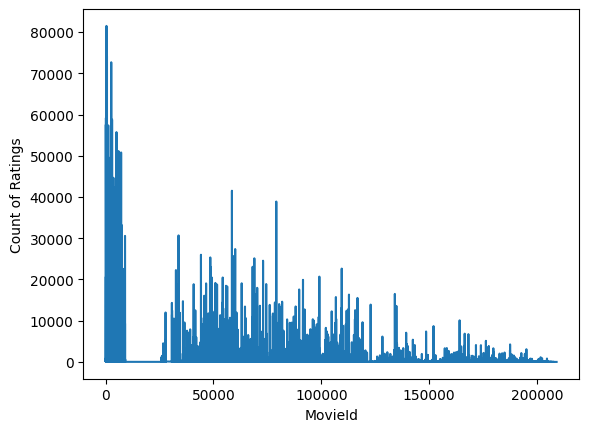

In [12]:
# testing how many ratings each movie has
ratings_distirbution = df_ratings_ratings.groupby("movieId").count()
ratings_distirbution = ratings_distirbution.reset_index()
plt.plot(ratings_distirbution["movieId"], ratings_distirbution["userId"])
plt.xlabel("MovieId")
plt.ylabel("Count of Ratings")

Although each user rates at least 20 movies in the datatset, this doesn't guarantee each movie has the same number of ratings. Also, ratings are on 0.5 scale, yet won't consider as categorical as makes sense to have mean values of ratings that are not 0.5 increments.

In [13]:
# filtering for movies with over 20 ratings
ratings_count = df_ratings_ratings.groupby("movieId")["rating"].count()
movies_with_20_plus_ratings = ratings_count[ratings_count > 20].index
filtered_ratings = df_ratings_ratings[df_ratings_ratings["movieId"].isin(movies_with_20_plus_ratings)].copy()

# taking the mean of each movie's rating
mean_ratings = filtered_ratings.groupby("movieId").mean()

# making the mean of each movie's rating an increment of 0.5
# mean_ratings["rating"] = filtered_ratings["rating"].apply(lambda x: round(x*2)/2)
mean_ratings = mean_ratings.reset_index()

In [14]:
# further cleaning of the ratings dataset is required before merging to the movies metadata
mean_ratings = mean_ratings.drop('userId', axis=1)
mean_ratings = mean_ratings.rename({'rating': 'mean_rating', 'timestamp': 'mean_rating_timestamp'}, axis=1)

# merging the average ratings to their movies through df_ratings_link
df_ratings_linked = pd.merge(df_ratings_link, mean_ratings, left_on='movieId', right_on='movieId')

# merging the ratings to df_movies_tmdb
df_movies_tmdb_ratings = pd.merge(df_movies_tmdb, df_ratings_linked, left_on='imdb_id', right_on='imdbId')

unique_ratings = len(df_movies_tmdb_ratings["title"].unique())
print(f"There are {unique_ratings} unique movies in our movies dataset that have ratings given by the found dataset.")

There are 11896 unique movies in our movies dataset that have ratings given by the found dataset.


In [15]:
# dropping many useless columns
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['id'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['status'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['vote_average'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['vote_count'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['backdrop_path'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['homepage'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['original_title'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['overview'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['popularity'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['poster_path'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['tagline'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['keywords'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['movieId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['imdbId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['tmdbId'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['adult'], axis = 1)
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(['production_countries'], axis = 1)

In [16]:
# replacing the runtime outliers with mean of non-outliers, assuming normality, apply +/- t*IQR of quantiles method
df_movies_tmdb_ratings = filling.fill_iqr(df_movies_tmdb_ratings, 'runtime', 3.5)

By doing this, we are losing some outliers which might be interesting to study. For example, late 1800s movies have usually very short runtimes and this might be interesting to investigate.

Dealing with multiple genres movies is not trivial. Exploding multiple-genres movies might be a solution but one needs to be careful about the influence of this on the overall statistics of the dataframe. A quick analysis on the #genres distribution shows the latter to be left-skewed, this implies that generally a movie has a low number of genres when this is larger than 1. This could justisfy the choice of exploding multiple genres movies. For later on analysis, a possible solution would be to choose unique movies starting from the standard movies dataframe, selecting a multiple repeated times movie based on the most relevant genre among the ones that belong to it.

The movie metadata wrangling is considered finished, and baseline visualizations of attributes within help in visualizing their contained data.

The mean number of genres of a given movie is:  5


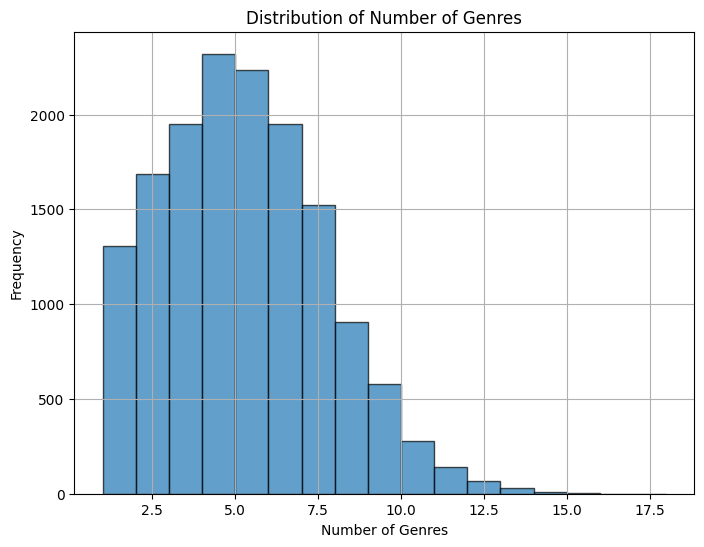

In [17]:
# getting the mean
print(f'The mean number of genres of a given movie is: ', math.ceil(df_movies_tmdb_ratings['genres'].apply(len).mean()))

# plotting the distribution
n_genres = df_movies_tmdb_ratings['genres'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(n_genres, bins=range(1, max(n_genres) + 2), edgecolor='black', alpha=0.7)
plt.title('Distribution of Number of Genres')
plt.xlabel('Number of Genres')
plt.ylabel('Frequency')
plt.grid(True)

In addition, when exploding only some relevant genre-wise movies copies will be kept. For example, if a movie has between genres 'Drama' and 'Acid western', with the first one being way more common than the second in the dataframe, only the movie copy with 'genre' == 'drama' is kept. This allows for a smaller influence of the explode operation on the overall statistics of the datframe, while maintaining a nice standard dataframe structure which is easy to handle genre-wise. 

In [18]:
# exploding df_movies_tmdb_ratings genres to retrieve most relevant ones -> Jake added, below, cleaning of the genres to avoid redundancy
df_movies_tmdb_ratings_exploded = df_movies_tmdb_ratings.explode("genres")

# making every genre's text uniform to assess unique genres
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.lower()

# removing redundant verbiage for genres
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace(" film", "")
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace(" movies", "")

# fixing some genres being as lists
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].map(str)
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace("[", "")
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace("]", "")
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace("'", "")
df_movies_tmdb_ratings_exploded["genres"] = df_movies_tmdb_ratings_exploded["genres"].str.replace('"', "")

In [19]:
# find and sort number of movies for each exploded genre
genres_counts = df_movies_tmdb_ratings_exploded.groupby("genres").size()
genres_counts = genres_counts.sort_values(axis=0, ascending=False)

# searching most relevant genres as the ones that correspond to 90% of the total data
genres_proportions = genres_counts.cumsum() / genres_counts.sum()
n = len(genres_proportions[genres_proportions < 0.9])
genres_relevant = genres_proportions.head(n).index.tolist()

In [20]:
# splitting single and multi-genres
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(len) > 1]
df_movies_tmdb_ratings = df_movies_tmdb_ratings[df_movies_tmdb_ratings['genres'].apply(len) == 1]

# selecting exploded movies whose genres are among the most relevant ones -> Jake added further cleaning of genres before choosing the most relevant ones
df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings_multi.explode('genres')

df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.lower()

df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace(" film", "")
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace(" movies", "")

df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].map(str)
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace("[", "")
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace("]", "")
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace("'", "")
df_movies_tmdb_ratings_multi["genres"] = df_movies_tmdb_ratings_multi["genres"].str.replace('"', "")

df_movies_tmdb_ratings_multi = df_movies_tmdb_ratings_multi[df_movies_tmdb_ratings_multi['genres'].isin(genres_relevant)]

# cleaning the single genre movies' genres
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].map(str)
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.lower()

df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace(" film", "")
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace(" movies", "")

df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].map(str)
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace("[", "")
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace("]", "")
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace("'", "")
df_movies_tmdb_ratings["genres"] = df_movies_tmdb_ratings["genres"].str.replace('"', "")

# joining the dataframes
df_movies_tmdb_ratings = pd.concat([df_movies_tmdb_ratings, df_movies_tmdb_ratings_multi], ignore_index=True)

# converting 'genres' column type
df_movies_tmdb_ratings['genres'] = df_movies_tmdb_ratings['genres'].astype(str)

Now that the genres column has been cleaned, a similar analysis needs to be performed for the 'spoken_languages' one and for 'countries'. Regarding the first one, since the TMDB dataset 'original_language' column has no missing values and has a standard format of one language per movie (e.g. en), this can be used without losing too much information or adding another heavy cleaning code. Considering the 'countries' column, one can follow a similar reasoning as before:

The mean number of countries of a given movie is:  2


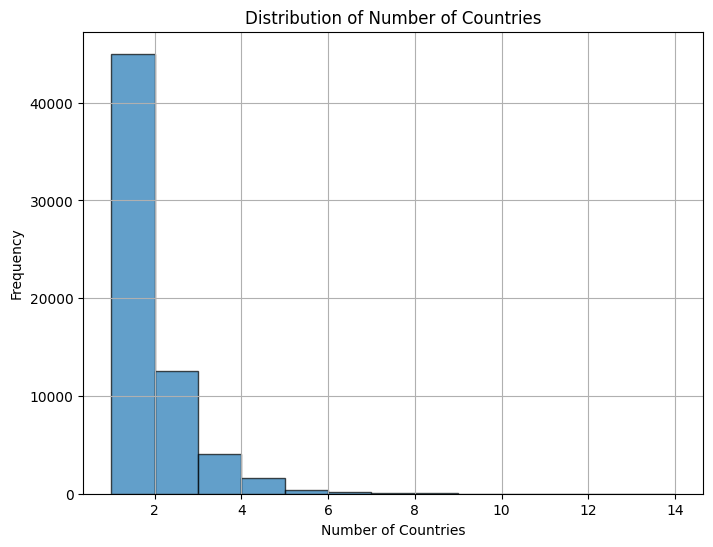

In [21]:
# dropping missing 'countries' entries
df_movies_tmdb_ratings.dropna(subset=['countries'], inplace=True)

# getting the mean
print(f'The mean number of countries of a given movie is: ', math.ceil(df_movies_tmdb_ratings['countries'].apply(len).mean()))

# plotting the distribution
n_countries = df_movies_tmdb_ratings['countries'].apply(len)
plt.figure(figsize=(8, 6))
plt.hist(n_countries, bins=range(1, max(n_countries) + 2), edgecolor='black', alpha=0.7)
plt.title('Distribution of Number of Countries')
plt.xlabel('Number of Countries')
plt.ylabel('Frequency')
plt.grid(True)

The distribution is heavily left-skewed. Therefore, exploding by countries will not alter the statistics of the dataframe in a too relevant way. Since the number of added entries through exploding is not too large and since one of the main interests of the team's datastory is the geographical analysis of movies, all countries will be kept (i.e. no relevant countries procedure will be applied, opposite to what has been done for genres). Note that, once again, depending on the interested analysis to be performed only one entry for a specific duplicated movie can be easily considered with the current dataframe structure.

In [22]:
# exploding countries
df_movies_tmdb_ratings = df_movies_tmdb_ratings.explode('countries')

In [23]:
# final ordering of the standard dataframe
df_movies_tmdb_ratings = df_movies_tmdb_ratings.sort_values(by='title')

# in the 'revenue' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['revenue'] = df_movies_tmdb_ratings['revenue'].replace(0.0, None)

# convert 'revenue' column to numeric values, raise error message in case of problems
df_movies_tmdb_ratings['revenue'] = pd.to_numeric(df_movies_tmdb_ratings['revenue'], errors='coerce')

In [24]:
# in the 'budget' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['budget'] = df_movies_tmdb_ratings['budget'].replace(0.0, None)

The final standard dataframe for movies data is `df_movies_tmdb_ratings`. The only columns which present some missing values are, in ascending order of missing data: `budget`, `'spoken_languages'` (recall that `'original_language'` with 0% missing data is available), `'production_companies'`, `'revenue'`.

In [25]:
unique_titles_now = len(df_movies_tmdb_ratings['title'].unique())
unique_titles_before = len(df_movies)
print(f"There are now {unique_titles_now} unique movies in the standard movies dataset.")
print(f"There were {unique_titles_before} unique movies in the initial movies dataset.")

There are now 11782 unique movies in the standard movies dataset.
There were 79347 unique movies in the initial movies dataset.


In [26]:
# deleting not used dataframes (but keeping the original ones)
del df_movies_tmdb
del df_movies_tmdb_ratings_exploded
del df_movies_tmdb_ratings_multi
del df_ratings_linked

### Adding `region` Column to the Master Dataframe

Part of our analysis involves considering geographical groupings, which have been manually clustered by production region.

In [27]:
# dictionary to map each country to a continent
country_to_region = {}
for region, countries in regions.items():
    for country in countries:
        country_to_region[country] = region

# Map the 'countries' column to the 'region' column
df_movies_tmdb_ratings['region'] = df_movies_tmdb_ratings['countries'].map(country_to_region)

# since df_movies_tmdb_ratings[df_movies_tmdb_ratings['continent'].isna()] shows that 2 entries
# have not been assigned to a continent, a quick check allows to see that this is due to an error 
# in the country (the specific movie is 'The Flying Scotsman'). These entries are therefore dropped
df_movies_tmdb_ratings = df_movies_tmdb_ratings.dropna(subset=['region'])

## Defining a master movies dataset
`df_movies_tmdb_ratings` is now one of the master dataframes. Since two columns have been exploded (`genres`, `revenues`) statistics might have been altered. Therefore, a smaller dataframe containing only unique titles must be defined to analyze features such as `revenue` or the ratings-related ones. Unique titles rows with the smallest amount of missing values among columns will be selected. This final master dataframe is `df_movies_tmdb_ratings_unique`.

In [28]:
df_movies_tmdb_ratings_unique = cleaning.drop_most_missing(df_movies_tmdb_ratings, ['title'])

# drop 'missing_values' column of df_movies_tmdb_ratings
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(columns=['missing_values'])

# dropping duplicates (just in case there are any duplicates after the selection process)
df_movies_tmdb_ratings_unique = df_movies_tmdb_ratings_unique.drop_duplicates(subset='title')

In [29]:
df_movies_tmdb_ratings_unique.head()

,wikipedia_id,freebase_id,title,release_date,revenue,runtime,spoken_languages,countries,genres,budget,imdb_id,original_language,production_companies,mean_rating,mean_rating_timestamp,region
1309,4213160,/m/0bq8q8,$,1971,NaN,119.0,[English Language],United States of America,crime fiction,None,68152,en,"Worldwide, Pan, Columbia Pictures",3.000000,1.382590e+09,North America
1314,20624798,/m/05222ld,$9.99,2008,NaN,78.0,[English Language],Israel,drama,None,790799,en,"Lama Films, Australian Film Finance Corporatio...",3.125000,1.364048e+09,North Africa and Middle East
1318,3610422,/m/09pt2f,'Neath the Arizona Skies,1934,NaN,52.0,[English Language],United States of America,action/adventure,None,24805,en,"Monogram Pictures, Lone Star",2.238095,1.325392e+09,North America
1326,24799628,/m/080nt72,'R Xmas,2001,NaN,83.0,"[English Language, Spanish Language]",United States of America,indie,None,217978,en,Barnholtz Entertainment,2.574074,1.373471e+09,North America
1327,20586022,/m/051wj3s,'Twas the Night Before Christmas,1974,NaN,60.0,None,United States of America,family,None,208654,en,Rankin/Bass Productions,3.437500,1.464166e+09,North America


In [30]:
df_movies_tmdb_ratings_unique.shape

(11696, 16)

# Characters Dataset Cleaning

Analogous to the movie metadata, the characters dataset must be wrangled.

In [31]:
# clean characters 'release_date' and 'actor_birth' to keep the release year only
df_characters['release_date'] = df_characters['release_date'].apply(cleaning.clean_dates)
df_characters['actor_birth'] = df_characters['actor_birth'].apply(cleaning.clean_dates)

The datastory will most focus on actor ethnicity, therefore particular attention is payed to the related columns in `df_characters`.

In [32]:
# counting the number of unique values in 'actor_ethnicity', excluding NaN
print(f"Number of unique ethnicities in 'actor_ethnicity': {df_characters['actor_ethnicity'].nunique(dropna=True)} \n")

# counting the number of NaN values in 'actor_ethnicity'
print(f"Number of NaN values in 'actor_ethnicity': {df_characters['actor_ethnicity'].isna().sum()}")

# total number of entries in 'actor_ethnicity' column
print(f"Total entries in 'actor_ethnicity': {len(df_characters['actor_ethnicity'])}")

# NaN entries proportion
nan_proportion_ethnicity = df_characters['actor_ethnicity'].isna().sum() / len(df_characters['actor_ethnicity'])
print(f"Proportion of NaN values in 'actor_ethnicity': {nan_proportion_ethnicity:.2%}")

Number of unique ethnicities in 'actor_ethnicity': 479 

Number of NaN values in 'actor_ethnicity': 344611
Total entries in 'actor_ethnicity': 450669
Proportion of NaN values in 'actor_ethnicity': 76.47%


In [33]:
# counting the number of unique actors who have a non-NaN ethnicity
print(f"Unique actors who have an ethnicity: {df_characters.dropna(subset=['actor_ethnicity'])['actor_name'].nunique()}")

# counting the number of unique actors in total
print(f"Total number of unique actors: {df_characters['actor_name'].nunique()} \n")

# counting the number of unique movies (using either 'freebase_id' or 'wikipedia_id')
print(f"Total number of unique movies: {df_characters['freebase_id'].nunique()}")

# counting the number of unique movies with at least one actor who has a specified ethnicity
print(f"Unique movies with at least one actor with ethnicity: {df_characters.dropna(subset=['actor_ethnicity'])['freebase_id'].nunique() }")

Unique actors who have an ethnicity: 8148
Total number of unique actors: 134078 

Total number of unique movies: 64330
Unique movies with at least one actor with ethnicity: 37958


Actors' ethnicities are in the format of Freebase IDs. To translate them, these unique IDs have been saved in a `.txt` file, which has been translated using `query.wikidata.org` by executing the following SPARQL request:

```sparql
SELECT DISTINCT ?freebase_id ?wikidata_id ?label WHERE {
  VALUES ?freebase_id {
    "/m/05bzpzx" "/m/064rb5l" "/m/01km_m" "/m/059v8" "/m/03b_13l" "/m/09c8kp" "/m/05ztd1" 
    "/m/04c28" "/m/03sk2" "/m/04jtjvt" "/m/03hjx6f" "/m/027936c" "/m/03nvq" "/m/03nz70" 
    "/m/01g3rx" "/m/02wz7j" "/m/04kdwcx" "/m/04_8lfc" "/m/033qt1" "/m/08j1fb" "/m/07wsyr" 
    "/m/06vb7b" "/m/012fh" "/m/0dm3xpw" "/m/09r2kh" "/m/02ry8mk" "/m/029q52" "/m/026d074" 
    "/m/013y54"
    # Add more IDs as needed
  }
  ?wikidata_id wdt:P646 ?freebase_id.
  ?wikidata_id rdfs:label ?label.
  FILTER(LANG(?label) = "en")
}

The creation of the `.txt` file is achieved by `src/data/freebase_to_batches.py` and the result is `src/data/unique_actor_ethnicities_batexhes.txt`. The outputs from query.wikidata.org have been saved in a .csv file (`freebaseids_labels.csv`)

In [34]:
# defining src/data/ path
SRC_DATA = './src/data/'

# reading the .csv and saving it to a dataframe
df_labels = pd.read_csv(SRC_DATA + 'freebaseids_label.csv')
df_labels.columns = ['freebase_id', 'wikipedia_id', 'label']  

# mapping dictionary definition
freebase_to_label = dict(zip(df_labels['freebase_id'], df_labels['label']))

# creating 'ethnicity_label' column where to map the freebse ethnicity Ids to the 
# corresponding labels
df_characters['ethnicity_label'] = df_characters['actor_ethnicity'].map(freebase_to_label)

In [35]:
# calculating the proportion of nans in 'ethnicity_label'
nan_proportion_label = df_characters['ethnicity_label'].isna().sum() / len(df_characters['ethnicity_label'])

# checking if any information have been lost during the ids-label translation
print(f"Proportion of NaN values in 'actor_ethnicity': {nan_proportion_ethnicity:.2%}")
print(f"Proportion of NaN values in 'ethnicity_label': {nan_proportion_label:.2%}")

Proportion of NaN values in 'actor_ethnicity': 76.47%
Proportion of NaN values in 'ethnicity_label': 77.17%


In [36]:
# printing some of the counts of unique values in 'ethnicity_label', excluding NaN
print("Unique values in 'ethnicity_label' and their counts:")
print(df_characters['ethnicity_label'].value_counts(dropna=True).head(10)) 

Unique values in 'ethnicity_label' and their counts:
ethnicity_label
Indians               16351
African Americans     10159
Jewish people         10121
English people         6165
Irish Americans        3857
Italian Americans      2956
White people           2307
White Americans        2250
Scottish Americans     2223
Irish people           1637
Name: count, dtype: int64


### Clustering Ethnicities & Adding Nationalities & Ethnicities from Wikidata:

In [37]:
# Load the dictionary from the .txt file
with open(SRC_DATA + "ethnicities_clusters.txt", "r") as file:
    ethnicities_clusters = ast.literal_eval(file.read())

# changed

In [38]:
#defining the ethnicity_to_clusters dictionary
ethnicity_to_clusters = {}
for cluster, labels in ethnicities_clusters.items():
    for label in labels:
        #checking if the label is already in the dictionary
        if label not in ethnicity_to_clusters:
            # init a new empty list
            ethnicity_to_clusters[label] = []
        # Add the cluster if not already in the list to avoid duplicates
        if cluster not in ethnicity_to_clusters[label]:
            ethnicity_to_clusters[label].append(cluster)

# Map each character's ethnicity to its unique clusters
df_characters['mapped_clusters'] = df_characters['ethnicity_label'].apply(
    lambda ethnicity: ethnicity_to_clusters.get(ethnicity, [])
)


In [39]:
# searching unique ethnicity labels where 'mapped_clusters' is missing
unmatched_ethnicities = df_characters[df_characters['mapped_clusters'].isna()]['ethnicity_label'].unique()

Since the labels are still incomplete for a large part, information from wikidata is adopted to enrich the `df_characters` dataframe. For each actor (using his freebase_id), a query has been requested to retrieve ethnicity or nationality if available. Everything is saved in `wikidata_actor_info.csv`.

In [40]:
# reading the .csv as a dataframe
df_wikidata = pd.read_csv(SRC_DATA + 'wikidata_actor_info.csv', sep=',')

# left merging df_characters and df_wikidata
df_characters = pd.merge(df_characters, df_wikidata, left_on="freebase_actor_id", right_on="freebaseID", how="left")

In [41]:
# Filling 'ethnicity_label', where necessary, with the new labels extracted from wikidata
# (either 'ethnicityLabel' or 'nationalityLabel' if the first is NaN or ambiguous)
def fill_ethnicity(row):
    if row['ethnicity_label'] in unmatched_ethnicities:
        # If the ethnicity is ambiguous, retrieve the nationality
        return row['nationalityLabel'] if pd.notna(row['nationalityLabel']) else (
            row['ethnicityLabel'] if pd.notna(row['ethnicityLabel']) else row['ethnicity_label'])
    else:
        # For non-ambiguous cases, retrieve the ethnicity label associated to it or fallback to nationality
        return row['ethnicity_label'] if pd.notna(row['ethnicity_label']) else (
            row['ethnicityLabel'] if pd.notna(row['ethnicityLabel']) else row['nationalityLabel']
        )

df_characters['ethnicity_label'] = df_characters.apply(fill_ethnicity, axis=1)

# printing the final results
print(f"Before filling, the proportion of NaN values in 'ethnicity_label' was: {nan_proportion_label:.2%}")

# re-computing the proportion of nan in 'ethnicity_labels'
nan_proportion_label = df_characters['ethnicity_label'].isna().sum() / len(df_characters['ethnicity_label'])
print(f"After filling, the proportion of NaN values in 'ethnicity_label' is: {nan_proportion_label:.2%}")


Before filling, the proportion of NaN values in 'ethnicity_label' was: 77.17%
After filling, the proportion of NaN values in 'ethnicity_label' is: 36.54%


The proportion of missing values in `'ethnicity_label'` has been halved through filling it with wikidata information. This allows to save a big part of the original dataframe when dropping nan values in the `'ethnicity_label'` column. Now, new ethnicities can be mapped to the clusters in `ethnicities_clusters.txt` file, after updating the latter. Note that, for simplicity, only the last updated version of this file is stored in `/src/data/`, therefore also in the first clustering this version has been adopted. 

In [42]:
new_ethnicity_to_clusters = {}
for cluster, labels in ethnicities_clusters.items():
    for label in labels:
        new_ethnicity_to_clusters.setdefault(label, []).append(cluster)

df_characters['mapped_clusters'] = df_characters['ethnicity_label'].apply(
    lambda ethnicity: list(set(new_ethnicity_to_clusters.get(ethnicity, [])))
)

In [43]:
df_characters.head(50)

,wikipedia_id,freebase_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,age_at_release,freebase_map,freebase_character_id,freebase_actor_id,ethnicity_label,mapped_clusters,freebaseID,actorLabel,ethnicityLabel,nationalityLabel
0,975900,/m/03vyhn,2001.0,Akooshay,1958.0,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,United States of America,[North Americans],/m/03wcfv7,Wanda De Jesus,NaN,United States of America
1,975900,/m/03vyhn,2001.0,Lieutenant Melanie Ballard,1974.0,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,Canada,[North Americans],/m/0346l4,Natasha Henstridge,NaN,Canada
2,975900,/m/03vyhn,2001.0,Desolation Williams,1969.0,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans,"[South and Central African, North Americans]",NaN,NaN,NaN,NaN
3,975900,/m/03vyhn,2001.0,Sgt Jericho Butler,1967.0,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,United Kingdom,[West European],/m/034hyc,Jason Statham,NaN,United Kingdom
4,975900,/m/03vyhn,2001.0,Bashira Kincaid,1977.0,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,United States of America,[North Americans],/m/01y9xg,Clea DuVall,NaN,United States of America
5,975900,/m/03vyhn,2001.0,Commander Helena Braddock,1949.0,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft,African Americans,"[South and Central African, North Americans]",NaN,NaN,NaN,NaN
6,975900,/m/03vyhn,2001.0,Whitlock,1945.0,F,1.753,NaN,Joanna Cassidy,56.0,/m/02vd6kw,/m/0bgchmx,/m/06lj1m,United States of America,[North Americans],/m/06lj1m,Joanna Cassidy,NaN,United States of America
7,975900,/m/03vyhn,2001.0,Big Daddy Mars,NaN,M,NaN,NaN,Richard Cetrone,NaN,/m/0bgchsy,/m/0bgcht0,/m/0bgcht7,NaN,[],NaN,NaN,NaN,NaN
8,975900,/m/03vyhn,2001.0,Michael Descanso,1971.0,M,1.892,NaN,Liam Waite,30.0,/m/03jqhb0,/m/0bgchs4,/m/0ks8b0,United States of America,[North Americans],/m/0ks8b0,Liam Waite,NaN,United States of America
9,975900,/m/03vyhn,2001.0,Uno,NaN,M,NaN,NaN,Duane Davis,NaN,/m/0bgchtj,/m/0bgchtm,/m/03nrwdy,United States of America,[North Americans],/m/03nrwdy,Duane Davis,NaN,United States of America


In [44]:
# Identify unmatched ethnicity labels
unmatched_ethnicities = df_characters[df_characters['ethnicity_label'].apply(
    lambda ethnicity: ethnicity not in ethnicity_to_clusters
)]['ethnicity_label']

# Count occurrences of unmatched ethnicity labels
unmatched_ethnicities_counts = unmatched_ethnicities.value_counts()

# Print the total number of unique unmatched ethnicity labels
print(f"Number of unmatched ethnicity labels: {unmatched_ethnicities_counts.shape[0]}")

# Print unmatched ethnicity labels with their counts
print("Unmatched ethnicity labels and their counts:")
print(unmatched_ethnicities_counts)

Number of unmatched ethnicity labels: 6
Unmatched ethnicity labels and their counts:
ethnicity_label
مسح                        9
multiracial people         4
Q25589681                  4
Karay-a people             2
Bohemian People            1
peoples of the Caucasus    1
Name: count, dtype: int64


For some ambiguous ethnicities, "Jewish People" whose actors may have several ethnicities/nationalities we attributed them to the category middle east as it accounts for Israel too. And Jewish in India were considered Israelian Jews also. Idk if we should precise that. 

In [45]:
df_characters.columns

Index(['wikipedia_id', 'freebase_id', 'release_date', 'character_name',
       'actor_birth', 'actor_gender', 'actor_height', 'actor_ethnicity',
       'actor_name', 'age_at_release', 'freebase_map', 'freebase_character_id',
       'freebase_actor_id', 'ethnicity_label', 'mapped_clusters', 'freebaseID',
       'actorLabel', 'ethnicityLabel', 'nationalityLabel'],
      dtype='object')

In [46]:
# dropping useless columns
#["freebase_id", "character_name", "actor_birth", "actor_height", "freebase_map","actor_ethnicity" ,"freebaseID","actorLabel", "nationalityLabel"], inplace=True)
df_characters= df_characters.drop(['freebaseID'], axis = 1)
df_characters= df_characters.drop(['actorLabel'], axis = 1)
df_characters= df_characters.drop(['ethnicityLabel'], axis = 1)
df_characters= df_characters.drop(['nationalityLabel'], axis = 1)
df_characters= df_characters.drop(['ethnicity_label'], axis = 1)
df_characters= df_characters.drop(['freebase_character_id'], axis = 1)
df_characters= df_characters.drop(['freebase_map'], axis = 1)
df_characters= df_characters.drop(['actor_height'], axis = 1)
df_characters= df_characters.drop(['character_name'], axis = 1)
df_characters=df_characters.drop(['actor_ethnicity'], axis = 1)
df_characters=df_characters.drop(['freebase_id'], axis = 1)

In [47]:
#renaming mapped cluster column
df_characters = df_characters.rename(columns={'mapped_clusters': 'actor_ethnicity'})
df_characters.head()


,wikipedia_id,release_date,actor_birth,actor_gender,actor_name,age_at_release,freebase_actor_id,actor_ethnicity
0,975900,2001.0,1958.0,F,Wanda De Jesus,42.0,/m/03wcfv7,[North Americans]
1,975900,2001.0,1974.0,F,Natasha Henstridge,27.0,/m/0346l4,[North Americans]
2,975900,2001.0,1969.0,M,Ice Cube,32.0,/m/01vw26l,"[South and Central African, North Americans]"
3,975900,2001.0,1967.0,M,Jason Statham,33.0,/m/034hyc,[West European]
4,975900,2001.0,1977.0,F,Clea DuVall,23.0,/m/01y9xg,[North Americans]


- This is the minimum of ambiguous ethnicities we could have. Those will remain inclassified since our analysis focuses on regions. 
- No dropping NA's for now as we will be investigating ethnicities and genders.

In [48]:
#deleting useless dfs
del df_labels
del df_wikidata
del unmatched_ethnicities
del unmatched_ethnicities_counts

## Merging characters with master dataframe for primary plots mainly

In [49]:
df_characters.columns

Index(['wikipedia_id', 'release_date', 'actor_birth', 'actor_gender',
       'actor_name', 'age_at_release', 'freebase_actor_id', 'actor_ethnicity'],
      dtype='object')

In [50]:
#creting new df merging character's data with master dataframe
df_movies_tmdb_ratings_characters = pd.merge(df_characters[['wikipedia_id','actor_gender','actor_ethnicity','freebase_actor_id']],
                             df_movies_tmdb_ratings_unique[['wikipedia_id','countries', 'title', 'release_date','genres','mean_rating','mean_rating_timestamp','region']], 
                             on='wikipedia_id', how='inner')


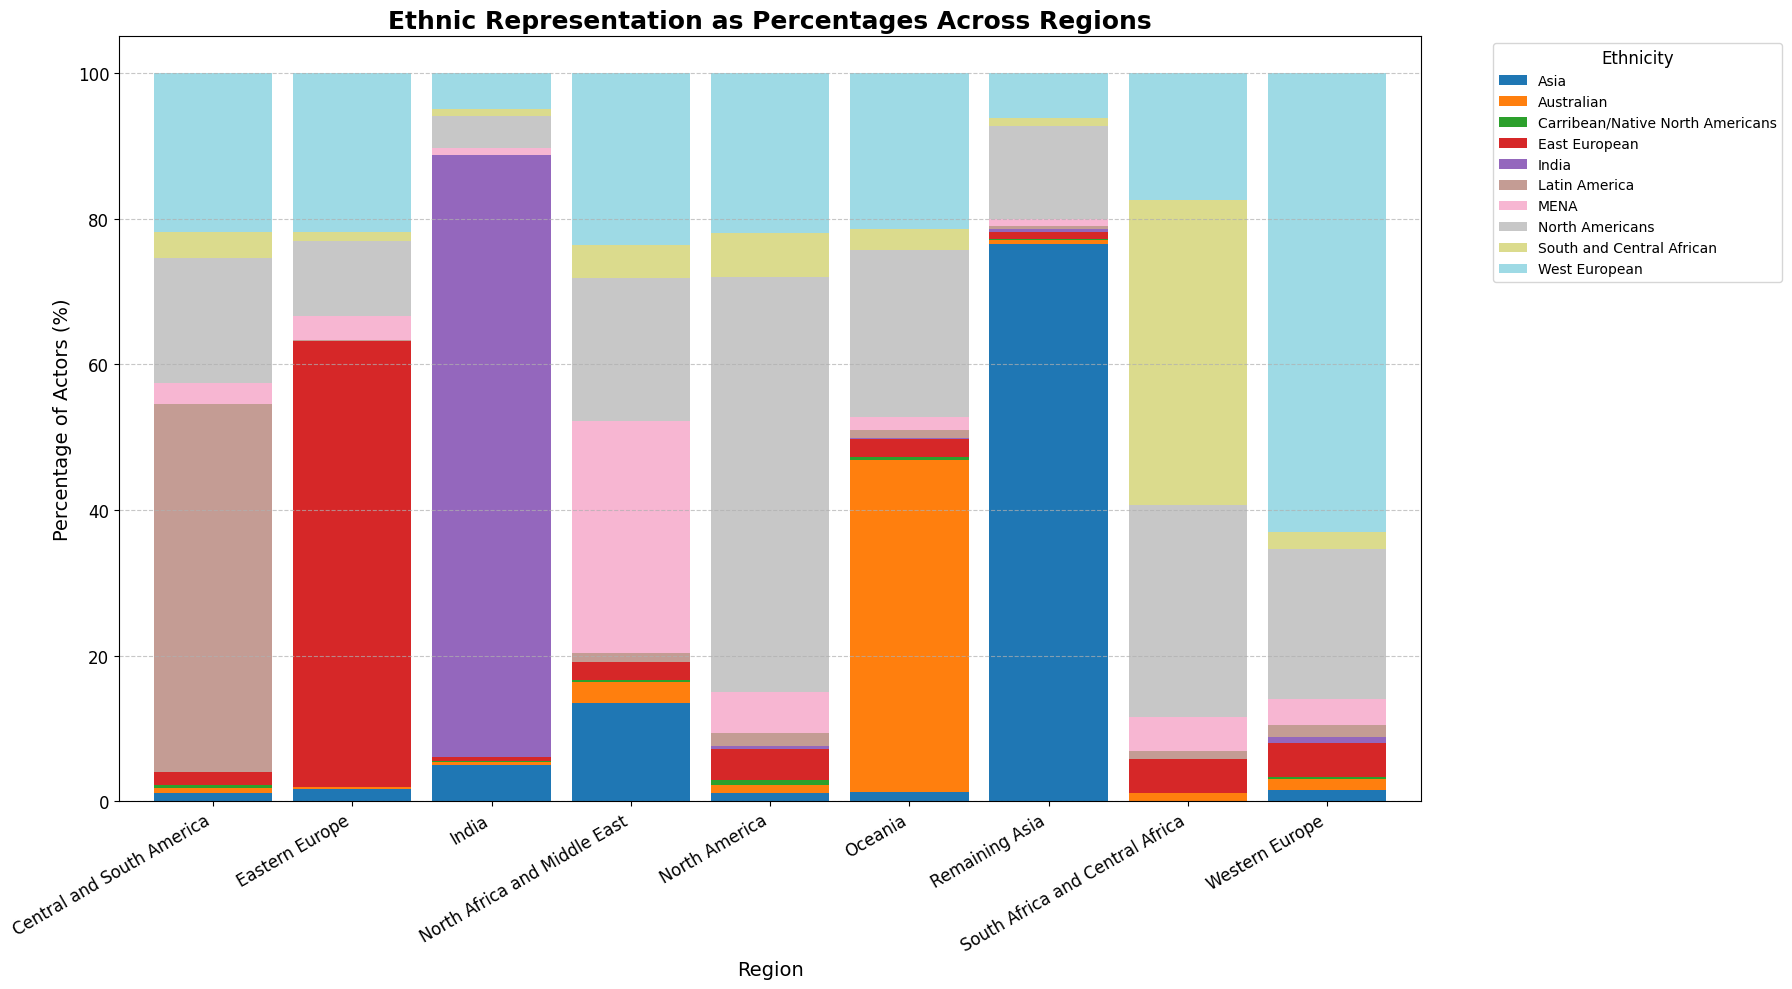

In [51]:
# Filter rows where both 'regions' and 'mapped_clusters' are not NaN
df_characters_region_ethnicity = df_movies_tmdb_ratings_characters.dropna(subset=['region', 'actor_ethnicity'])

# Explode the 'mapped_clusters' column to handle lists
df_characters_region_ethnicity_exploded = df_characters_region_ethnicity.explode('actor_ethnicity')

# Ethnicity representation by region
region_ethnicity_trends = df_characters_region_ethnicity_exploded.groupby(['region', 'actor_ethnicity']).size().unstack(fill_value=0)

# Calculate percentages for each region
region_ethnicity_percent = region_ethnicity_trends.div(region_ethnicity_trends.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart with percentages
plt.figure(figsize=(18, 10))  # Larger figure size for readability
region_ethnicity_percent.plot(kind='bar', stacked=True, colormap='tab20', width=0.85, ax=plt.gca())

# Labeling and layout improvements
plt.xlabel("Region", fontsize=14)
plt.ylabel("Percentage of Actors (%)", fontsize=14)
plt.title("Ethnic Representation as Percentages Across Regions", fontsize=18, fontweight='bold')

# Adjust x-tick rotation for readability
plt.xticks(rotation=30, ha="right", fontsize=12)

plt.yticks(fontsize=12)
plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)

# Optional: add horizontal grid lines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()
plt.show()


## Creating the Ethnicity score - using characters dataframe

What interests us is how the demographics of the cast members of one movie may impact it's ratings. We'll look at their ethnicities and their genders. This two features have to be quantified through an ethnicity_score and a gender_score per movie, reflecting not only the proportions but the distribution of the cast. A movie with 10 ethnicities represented equally (balanced distribution) should score higher in diversity than a movie with 10 ethnicities but dominated by one ethnicity. This is where the Shannon Diversity Index (SDI) becomes valuable because we are not capturing the true spread of diversity.
- **Shannon Index** offers a balanced measure of diversity, reducing the impact of outliers and providing a more accurate view of diversity distribution. We will be looking at the entropy of distribution. 
$$
H = - \sum_{i=1}^{n} p_i \ln(p_i)
$$

Where:

- \(H\): Shannon Diversity Index  
- \(p_i\): Proportion of individuals in the \(i\)-th category (ethnicity)  
- \(n\): Total number of categories (ethnicities)  




## 1-Ethnicity Score 

First we create a new dataframe which will contain the movie_id , number of characters of each movie , and proportion of individuals of each ethnicity in each movie, and finally the SDI ethnicity score for each movie. 

In [52]:
df_characters.shape

(480647, 8)

In [53]:
#filtering actors with no ethnicities by filtering nans and empty lists
df_filtered = df_characters[
    df_characters['actor_ethnicity'].notna() & df_characters['actor_ethnicity'].apply(lambda x: len(x) > 0)
]

In [54]:
df_filtered.shape 

(305000, 8)

In [55]:
#Df for ethnicity diversity score
df_ethnicity_exploded = df_filtered.explode('actor_ethnicity')

In [56]:
# Occurrences of each ethnicity per movie
ethnicity_counts = df_ethnicity_exploded.groupby(['wikipedia_id', 'actor_ethnicity']).size().reset_index(name='ethnicity_count')
# since df_ethnicity is exploded based on ethnicities, counting the nb of entries simply gives total nb of ethnicities in the movie
total_actors = df_ethnicity_exploded.groupby('wikipedia_id').size().reset_index(name='total_actors')
# Merge counts back into exploded dataframe
df_ethnicity_counts = ethnicity_counts.merge(total_actors, on='wikipedia_id')
# Proportions for each ethnicity
df_ethnicity_counts['ethnicity_proportion'] = df_ethnicity_counts['ethnicity_count'] / df_ethnicity_counts['total_actors']

df_ethnicity_counts.head(20) 


,wikipedia_id,actor_ethnicity,ethnicity_count,total_actors,ethnicity_proportion
0,330,West European,1,1,1.000000
1,3217,East European,1,13,0.076923
2,3217,North Americans,9,13,0.692308
3,3217,West European,3,13,0.230769
4,3333,North Americans,12,14,0.857143
5,3333,West European,2,14,0.142857
6,3746,Asia,1,12,0.083333
7,3746,Latin America,1,12,0.083333
8,3746,North Americans,8,12,0.666667
9,3746,West European,2,12,0.166667


In [57]:
def shannon_entropy(proportions):
    """
    Calculates the Shannon entropy given a list or series of proportions.
    
    Parameters:
    proportions (list or pd.Series): Proportions of categories in a group.
    
    Returns:
    float: Shannon entropy (diversity index).
    """
    return -np.sum(proportions * np.log(proportions))



In [58]:
# Calculate SDI for each movie
df_sdi = df_ethnicity_counts.groupby('wikipedia_id').apply(
    lambda group: shannon_entropy(group['ethnicity_proportion'])
).reset_index(name='SDI_ethnicity')

# Merge the SDI scores back to the original dataframe
df_ethnicity_counts = df_ethnicity_counts.merge(df_sdi, on='wikipedia_id')

#Drop duplicates for distribution analysis 
df_ethnicity_counts = df_ethnicity_counts.drop_duplicates(subset='wikipedia_id')

df_ethnicity_counts.head()


/var/folders/zw/3d22h42x67lctzjb8rx_3bdm0000gn/T/ipykernel_5070/2729616537.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sdi = df_ethnicity_counts.groupby('wikipedia_id').apply(


,wikipedia_id,actor_ethnicity,ethnicity_count,total_actors,ethnicity_proportion,SDI_ethnicity
0,330,West European,1,1,1.000000,-0.000000
1,3217,East European,1,13,0.076923,0.790268
4,3333,North Americans,12,14,0.857143,0.410116
6,3746,Asia,1,12,0.083333,0.983088
10,3837,East European,2,22,0.090909,1.236540


In [59]:
df_ethnicity_counts["SDI_ethnicity"].describe()

count    59557.000000
mean         0.392283
std          0.443042
min         -0.000000
25%          0.000000
50%          0.000000
75%          0.693147
max          1.858519
Name: SDI_ethnicity, dtype: float64

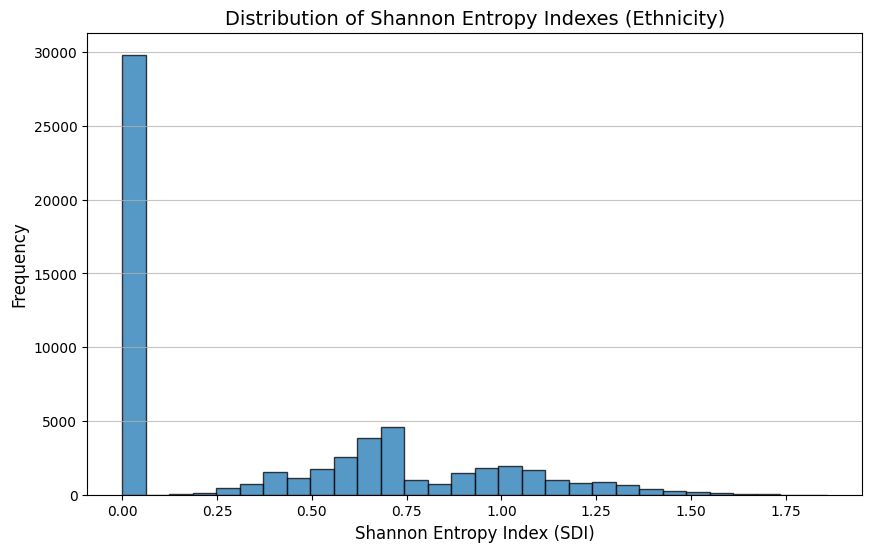

In [60]:
# Plot the distribution of Shannon entropy indexes
plt.figure(figsize=(10, 6))
plt.hist(df_ethnicity_counts['SDI_ethnicity'], bins=30, alpha=0.75, edgecolor='black')
plt.title('Distribution of Shannon Entropy Indexes (Ethnicity)', fontsize=14)
plt.xlabel('Shannon Entropy Index (SDI)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

High values = High diversity and balanced distribution of the ethnicities of the cast, no dominance of one ethnicity over the others. 
Lower value = No diversity / All cast members have the same one ethnicity. 

## 2-Gender Score 

## A -Shannon diversity index

In [61]:
df_characters.shape

(480647, 8)

In [62]:
df_characters_gender = df_characters.dropna(subset=['actor_gender'])

df_characters_gender.shape

(433879, 8)

In [63]:
# For Gender Diversity Index (SDI)
# Ooccurrences of each gender per movie
gender_counts = df_characters_gender.groupby(['wikipedia_id', 'actor_gender']).size().reset_index(name='gender_count')
# Total number of actors per movie
total_actors_per_movie = df_characters_gender.groupby('wikipedia_id').size().reset_index(name='total_actors')
#Merge the counts back into a single dataframe
df_gender_counts = gender_counts.merge(total_actors_per_movie, on='wikipedia_id')
# Proportions for each gender
df_gender_counts['gender_proportion'] = df_gender_counts['gender_count'] / df_gender_counts['total_actors']

# Step 5: Calculate SDI for each movie
df_sdi_gender = df_gender_counts.groupby('wikipedia_id').apply(
    lambda group: shannon_entropy(group['gender_proportion'])
).reset_index(name='SDI_gender')

# Merge the SDI scores back
df_gender_counts = df_gender_counts.merge(df_sdi_gender, on='wikipedia_id')
#dropping duplicates keeping unique entry per movie 
df_gender_counts = df_gender_counts.drop_duplicates(subset='wikipedia_id')
df_gender_counts.head()


/var/folders/zw/3d22h42x67lctzjb8rx_3bdm0000gn/T/ipykernel_5070/2184839285.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sdi_gender = df_gender_counts.groupby('wikipedia_id').apply(


,wikipedia_id,actor_gender,gender_count,total_actors,gender_proportion,SDI_gender
0,330,F,4,4,1.000000,-0.000000
1,3217,F,3,13,0.230769,0.540204
3,3333,F,6,15,0.400000,0.673012
5,3746,F,3,14,0.214286,0.519580
7,3837,F,2,20,0.100000,0.325083


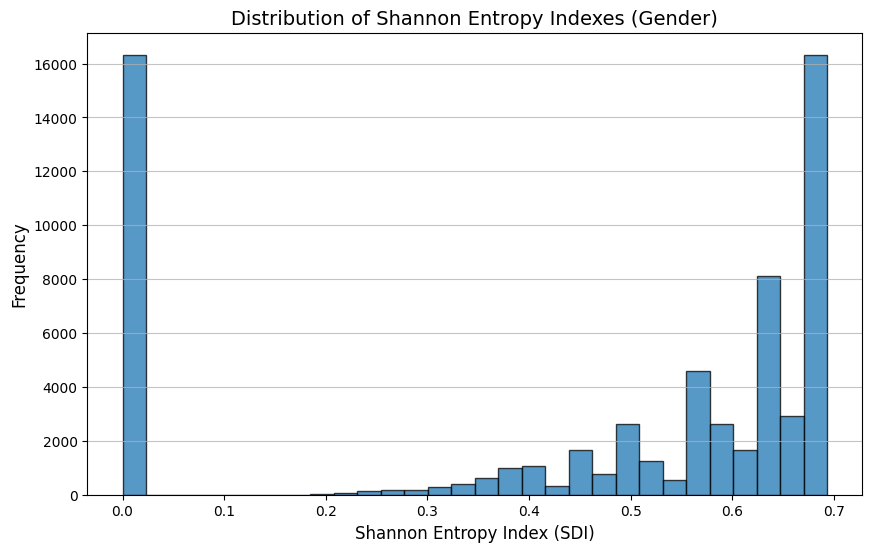

In [64]:
# Plot the distribution of Shannon entropy indexes
plt.figure(figsize=(10, 6))
plt.hist(df_gender_counts['SDI_gender'], bins=30, alpha=0.75, edgecolor='black')
plt.title('Distribution of Shannon Entropy Indexes (Gender)', fontsize=14)
plt.xlabel('Shannon Entropy Index (SDI)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

Here, many films cluster around a moderate to relatively high SDI (around 0.6–0.7), suggesting that a substantial portion have a fairly mixed gender distribution, while a noticeable subset score near zero, indicating casts composed of only one gender.

## Now back to the original data frame: 

Adding Diversity and gender scores to original master dataframe. 

In [65]:
df_movies_tmdb_ratings_unique.shape

(11696, 16)

In [66]:
# Merge SDI_ethnicity
df_movies_tmdb_ratings_unique = df_movies_tmdb_ratings_unique.merge(
    df_ethnicity_counts[['wikipedia_id', 'SDI_ethnicity']],
    on='wikipedia_id',
    how='left'
)
# Merge SDI_gender and GPR
df_movies_tmdb_ratings_unique = df_movies_tmdb_ratings_unique.merge(
    df_gender_counts[['wikipedia_id', 'SDI_gender']],
    on='wikipedia_id',
    how='left'
)


In [67]:
# Adding nb of actors per movie:
#Number of actors per movie: 
# Unique actors per movie as each entry of df_characters is a character in the movie 
actors_per_movie = df_characters.groupby('wikipedia_id')['freebase_actor_id'].nunique()
# Map the count back to the original dataframe
df_movies_tmdb_ratings_unique['nb_actors'] = df_movies_tmdb_ratings_unique['wikipedia_id'].map(actors_per_movie)
df_movies_tmdb_ratings_unique.head()

,wikipedia_id,freebase_id,title,release_date,revenue,runtime,spoken_languages,countries,genres,budget,imdb_id,original_language,production_companies,mean_rating,mean_rating_timestamp,region,SDI_ethnicity,SDI_gender,nb_actors
0,4213160,/m/0bq8q8,$,1971,NaN,119.0,[English Language],United States of America,crime fiction,None,68152,en,"Worldwide, Pan, Columbia Pictures",3.000000,1.382590e+09,North America,0.955700,0.562335,9.0
1,20624798,/m/05222ld,$9.99,2008,NaN,78.0,[English Language],Israel,drama,None,790799,en,"Lama Films, Australian Film Finance Corporatio...",3.125000,1.364048e+09,North Africa and Middle East,-0.000000,0.348832,9.0
2,3610422,/m/09pt2f,'Neath the Arizona Skies,1934,NaN,52.0,[English Language],United States of America,action/adventure,None,24805,en,"Monogram Pictures, Lone Star",2.238095,1.325392e+09,North America,0.450561,0.682908,7.0
3,24799628,/m/080nt72,'R Xmas,2001,NaN,83.0,"[English Language, Spanish Language]",United States of America,indie,None,217978,en,Barnholtz Entertainment,2.574074,1.373471e+09,North America,1.494175,0.598270,11.0
4,20586022,/m/051wj3s,'Twas the Night Before Christmas,1974,NaN,60.0,None,United States of America,family,None,208654,en,Rankin/Bass Productions,3.437500,1.464166e+09,North America,-0.000000,0.562335,4.0


In [68]:
# deleting not used dataframes (but keeping the original ones)
del df_filtered # df_characters without missing ethnicities
del df_ethnicity_exploded
del total_actors
del df_sdi


del df_characters_gender
del total_actors_per_movie
del df_sdi_gender


In [69]:
df_movies_tmdb_ratings_unique.shape

(11696, 19)

In [70]:
df_movies_tmdb_ratings_unique.head()

,wikipedia_id,freebase_id,title,release_date,revenue,runtime,spoken_languages,countries,genres,budget,imdb_id,original_language,production_companies,mean_rating,mean_rating_timestamp,region,SDI_ethnicity,SDI_gender,nb_actors
0,4213160,/m/0bq8q8,$,1971,NaN,119.0,[English Language],United States of America,crime fiction,None,68152,en,"Worldwide, Pan, Columbia Pictures",3.000000,1.382590e+09,North America,0.955700,0.562335,9.0
1,20624798,/m/05222ld,$9.99,2008,NaN,78.0,[English Language],Israel,drama,None,790799,en,"Lama Films, Australian Film Finance Corporatio...",3.125000,1.364048e+09,North Africa and Middle East,-0.000000,0.348832,9.0
2,3610422,/m/09pt2f,'Neath the Arizona Skies,1934,NaN,52.0,[English Language],United States of America,action/adventure,None,24805,en,"Monogram Pictures, Lone Star",2.238095,1.325392e+09,North America,0.450561,0.682908,7.0
3,24799628,/m/080nt72,'R Xmas,2001,NaN,83.0,"[English Language, Spanish Language]",United States of America,indie,None,217978,en,Barnholtz Entertainment,2.574074,1.373471e+09,North America,1.494175,0.598270,11.0
4,20586022,/m/051wj3s,'Twas the Night Before Christmas,1974,NaN,60.0,None,United States of America,family,None,208654,en,Rankin/Bass Productions,3.437500,1.464166e+09,North America,-0.000000,0.562335,4.0


# Impact of our indexes on ratings: 


## 1 - are ratings impacted by nb of actors per movie ? 

In [71]:
df_nb_actors = df_movies_tmdb_ratings_unique.dropna(subset=['mean_rating', 'nb_actors'])
# basic statistics
print(df_nb_actors[['mean_rating', 'nb_actors']].describe())

        mean_rating     nb_actors
count  11360.000000  11360.000000
mean       3.218634     11.465053
std        0.484553      5.831074
min        1.000000      0.000000
25%        2.919891      8.000000
50%        3.278007     11.000000
75%        3.576087     15.000000
max        4.413576    115.000000


In [72]:
# Calculate Pearson correlation
pearson_corr, pearson_p = pearsonr(df_nb_actors['mean_rating'], df_nb_actors['nb_actors'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# Calculate Spearman correlation
spearman_corr, spearman_p = spearmanr(df_nb_actors['mean_rating'], df_nb_actors['nb_actors'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")


Pearson correlation: 0.0049, p-value: 0.6027
Spearman correlation: -0.0124, p-value: 0.1851


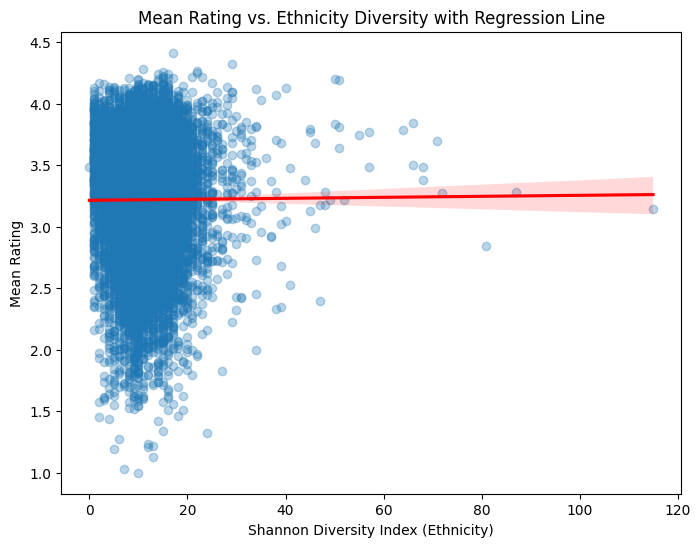

In [73]:
plt.figure(figsize=(8,6))
sns.regplot(
    x='nb_actors', 
    y='mean_rating', 
    data=df_nb_actors, 
    scatter_kws={'alpha':0.3}, 
    line_kws={'color':'red'}
)
plt.xlabel('Shannon Diversity Index (Ethnicity)')
plt.ylabel('Mean Rating')
plt.title('Mean Rating vs. Ethnicity Diversity with Regression Line')
plt.show()

In [74]:
import statsmodels.api as sm

# Add a constant for regression
X = sm.add_constant(df_nb_actors['nb_actors'])
y = df_nb_actors['mean_rating']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            mean_rating   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2710
Date:                Thu, 12 Dec 2024   Prob (F-statistic):              0.603
Time:                        14:55:05   Log-Likelihood:                -7887.9
No. Observations:               11360   AIC:                         1.578e+04
Df Residuals:                   11358   BIC:                         1.579e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2140      0.010    320.464      0.0

- Nb of actors isn't statistically significant  at all

## Ethnicity Index and Mean Ratings

In [75]:
df_correlation_ethnicity = df_movies_tmdb_ratings_unique[['mean_rating', 'SDI_ethnicity']].dropna()

# Calculate Pearson correlation
pearson_corr, pearson_p = pearsonr(df_correlation_ethnicity['mean_rating'], df_correlation_ethnicity['SDI_ethnicity'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# Calculate Spearman correlation
spearman_corr, spearman_p = spearmanr(df_correlation_ethnicity['mean_rating'], df_correlation_ethnicity['SDI_ethnicity'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")


Pearson correlation: -0.1778, p-value: 0.0000
Spearman correlation: -0.1852, p-value: 0.0000


Statistical significance but very mow values. 

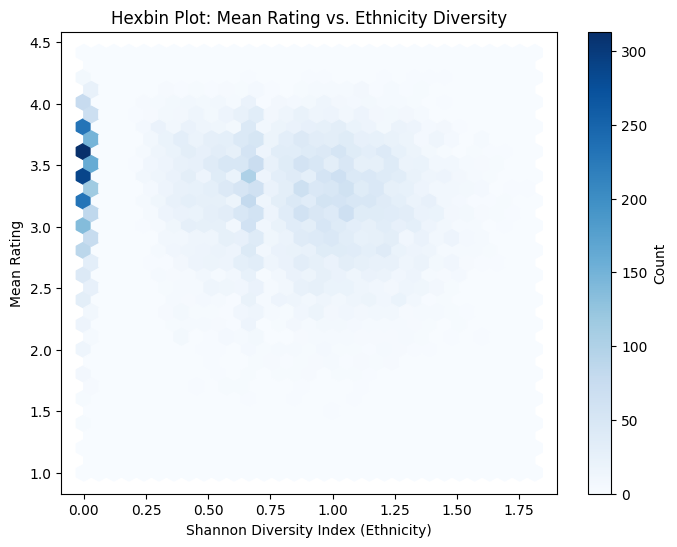

In [76]:
plt.figure(figsize=(8,6))
plt.hexbin(df_correlation_ethnicity['SDI_ethnicity'], 
           df_correlation_ethnicity['mean_rating'], 
           gridsize=30, 
           cmap='Blues')
plt.xlabel('Shannon Diversity Index (Ethnicity)')
plt.ylabel('Mean Rating')
plt.title('Hexbin Plot: Mean Rating vs. Ethnicity Diversity')
plt.colorbar(label='Count')
plt.show()


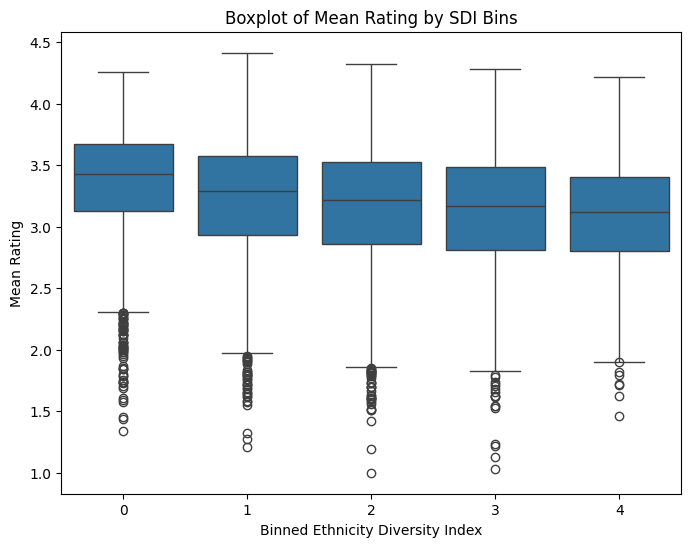

In [77]:

df_binned = df_correlation_ethnicity.copy()
df_binned['SDI_bin'] = pd.cut(df_binned['SDI_ethnicity'], bins=5, labels=False)

plt.figure(figsize=(8,6))
sns.boxplot(x='SDI_bin', y='mean_rating', data=df_binned)
plt.xlabel('Binned Ethnicity Diversity Index')
plt.ylabel('Mean Rating')
plt.title('Boxplot of Mean Rating by SDI Bins')
plt.show()


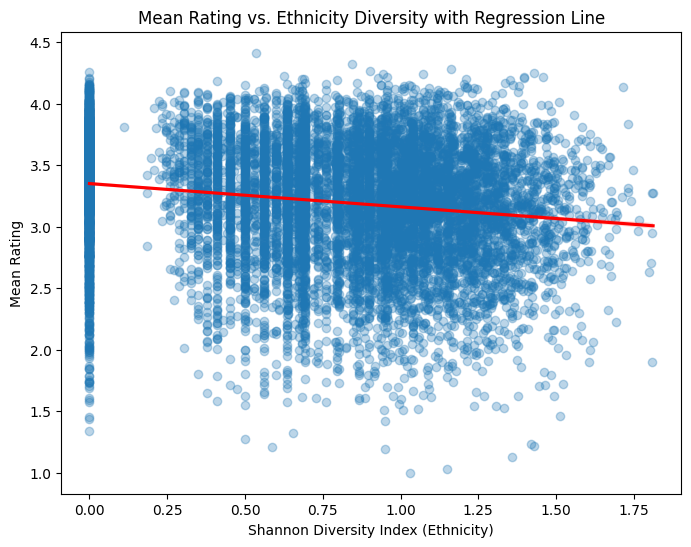

In [78]:
plt.figure(figsize=(8,6))
sns.regplot(
    x='SDI_ethnicity', 
    y='mean_rating', 
    data=df_correlation_ethnicity, 
    scatter_kws={'alpha':0.3}, 
    line_kws={'color':'red'}
)
plt.xlabel('Shannon Diversity Index (Ethnicity)')
plt.ylabel('Mean Rating')
plt.title('Mean Rating vs. Ethnicity Diversity with Regression Line')
plt.show()


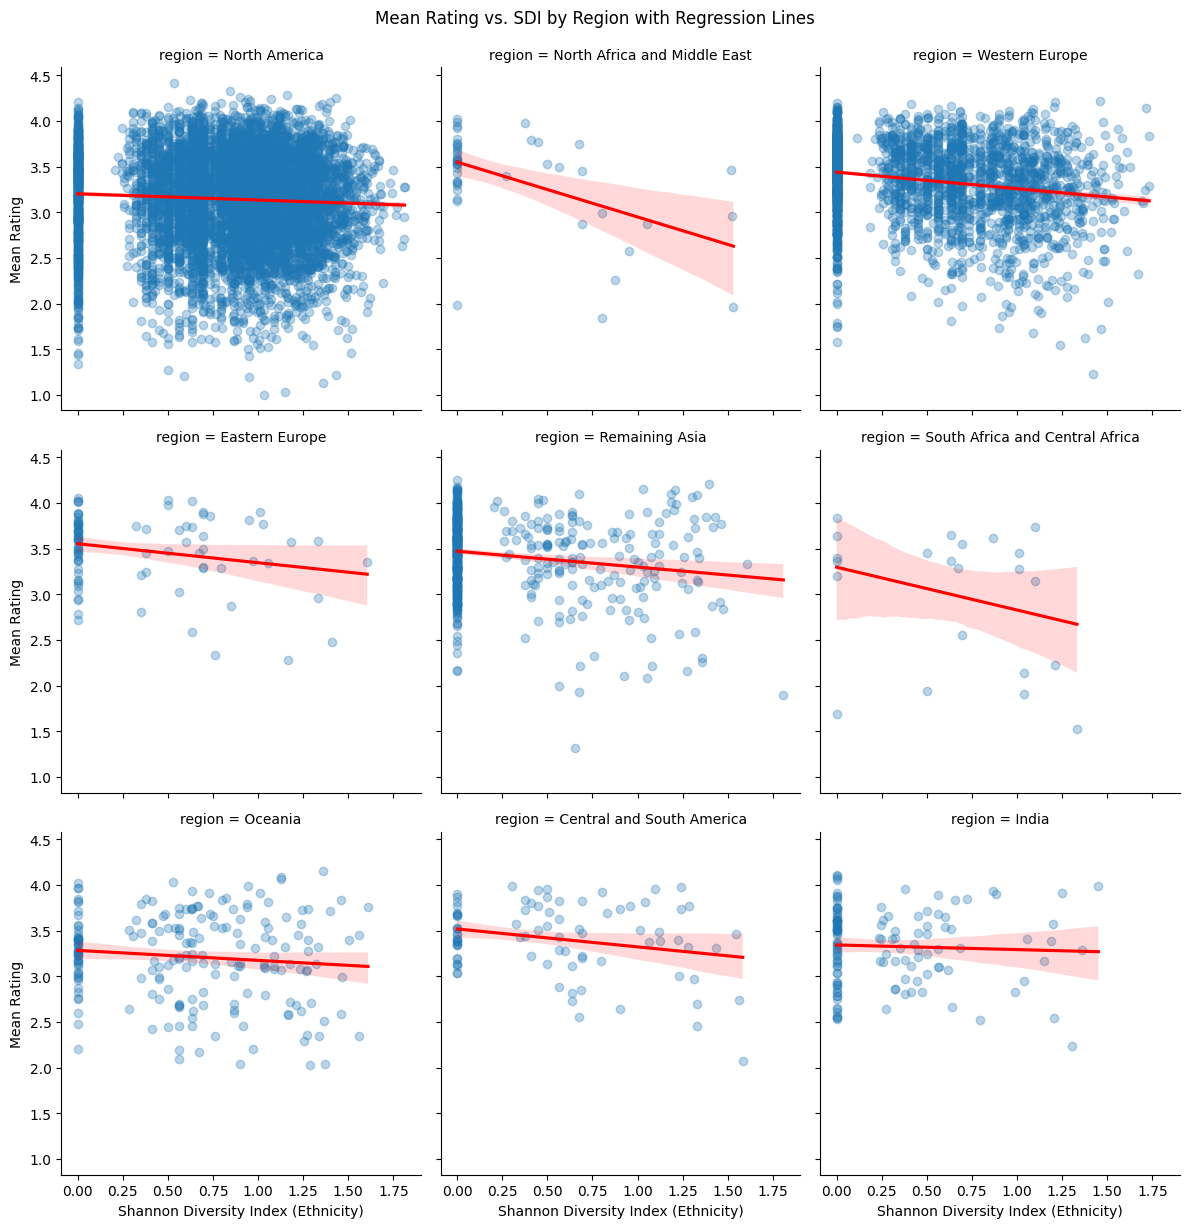

In [79]:
g = sns.FacetGrid(df_movies_tmdb_ratings_unique, col='region', col_wrap=3, height=4)
#including regression lines
g.map(
    sns.regplot, 
    'SDI_ethnicity', 
    'mean_rating', 
    scatter_kws={'alpha': 0.3},  # Adjust transparency of points
    line_kws={'color': 'red'}   # Set regression line color
)
g.set_axis_labels('Shannon Diversity Index (Ethnicity)', 'Mean Rating')
g.fig.suptitle('Mean Rating vs. SDI by Region with Regression Lines', y=1.02)


plt.show()

/var/folders/zw/3d22h42x67lctzjb8rx_3bdm0000gn/T/ipykernel_5070/1839536484.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_by_region = df_binned.groupby(['region', 'SDI_bin'])['mean_rating'].mean().reset_index()


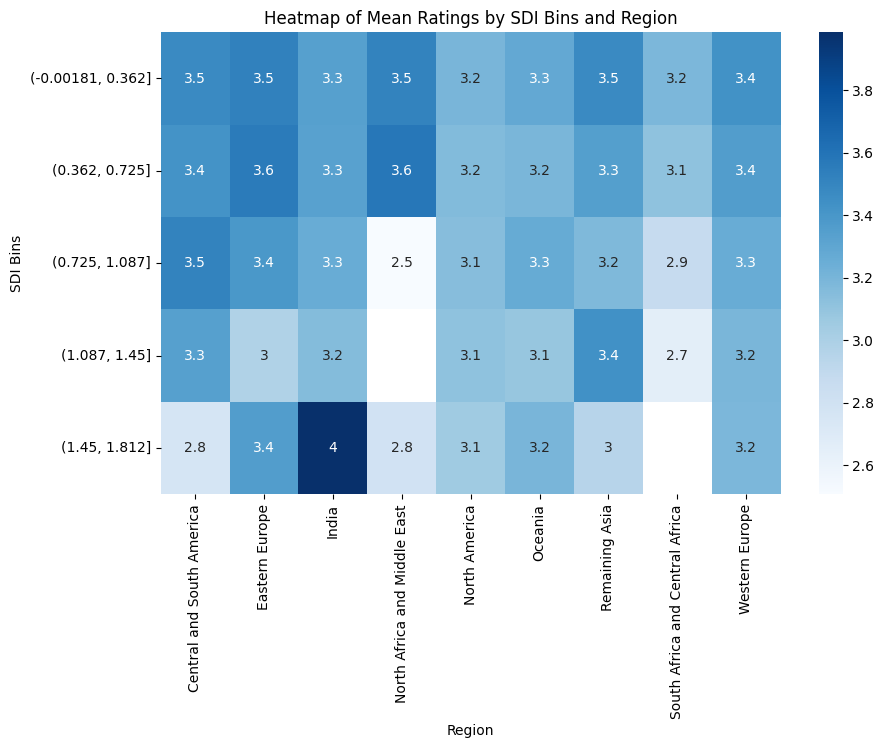

In [80]:
# Create bins for SDI
df_binned = df_movies_tmdb_ratings_unique.copy()
df_binned['SDI_bin'] = pd.cut(df_binned['SDI_ethnicity'], bins=5)

# Aggregate mean rating per bin per region
avg_by_region = df_binned.groupby(['region', 'SDI_bin'])['mean_rating'].mean().reset_index()
pivot = avg_by_region.pivot(index='SDI_bin', columns='region', values='mean_rating')
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, cmap='Blues')
plt.title('Heatmap of Mean Ratings by SDI Bins and Region')
plt.xlabel('Region')
plt.ylabel('SDI Bins')
plt.show()

## statistics on the genders score

In [81]:
df_correlation_gender = df_movies_tmdb_ratings_unique[['mean_rating', 'SDI_gender']].dropna()

# Calculate Pearson correlation
pearson_corr, pearson_p = pearsonr(df_correlation_gender['mean_rating'], df_correlation_gender['SDI_gender'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# Calculate Spearman correlation
spearman_corr, spearman_p = spearmanr(df_correlation_gender['mean_rating'], df_correlation_gender['SDI_gender'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

Pearson correlation: -0.0778, p-value: 0.0000
Spearman correlation: -0.0504, p-value: 0.0000


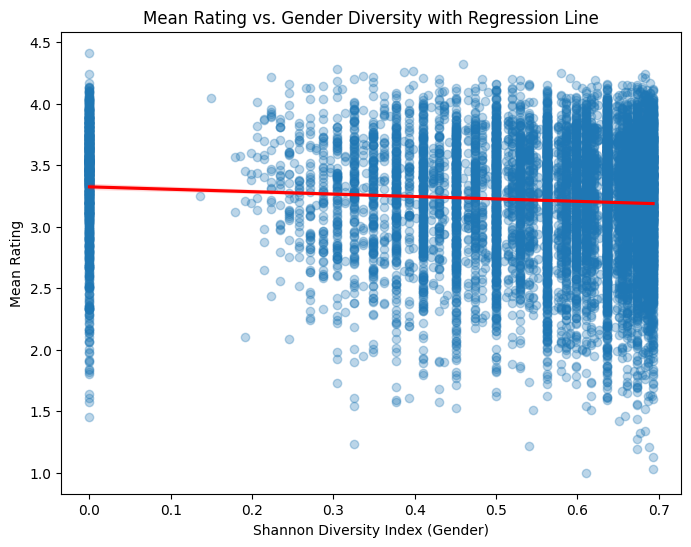

In [82]:
plt.figure(figsize=(8,6))
sns.regplot(
    x='SDI_gender', 
    y='mean_rating', 
    data=df_correlation_gender, 
    scatter_kws={'alpha':0.3}, 
    line_kws={'color':'red'}
)
plt.xlabel('Shannon Diversity Index (Gender)')
plt.ylabel('Mean Rating')
plt.title('Mean Rating vs. Gender Diversity with Regression Line')
plt.show()

## Nb of languages per movie matters? 

In [83]:
# Explode the languages column so each language gets its own row
df_languages_exploded = df_movies_tmdb_ratings_unique.explode('spoken_languages')
# Group by language and calculate the mean rating
mean_rating_per_language = df_languages_exploded.groupby('spoken_languages')['mean_rating'].mean().reset_index()
# Sort by rating to see the most and least impactful languages
mean_rating_per_language = mean_rating_per_language.sort_values(by='mean_rating', ascending=False)
print(mean_rating_per_language.head())


         spoken_languages  mean_rating
127     Sicilian Language     4.324336
26       Catalan language     3.949596
80         Khmer language     3.928571
64         Hmong language     3.909368
22   Brazilian Portuguese     3.895204


We add filter empty lists of spoken languages and drop na_s and see if the nb of spoken languages is correlated to the mean rating

In [85]:
# Drop rows where spoken_languages is NaN
df_movies_with_languages = df_movies_tmdb_ratings_unique.dropna(subset=['spoken_languages'])
# Drop rows where spoken_languages is an empty list
df_movies_with_languages = df_movies_with_languages[
    df_movies_with_languages['spoken_languages'].apply(lambda x: len(x) > 0)
]

# Check the resulting dataframe
print(df_movies_with_languages[['wikipedia_id', 'spoken_languages']].head())


   wikipedia_id                      spoken_languages
0       4213160                    [English Language]
1      20624798                    [English Language]
2       3610422                    [English Language]
3      24799628  [English Language, Spanish Language]
5       8098268                    [English Language]


In [86]:
# Count the number of languages per movie
df_movies_with_languages['nb_languages'] = df_movies_with_languages['spoken_languages'].apply(len)
# Check the updated dataframe
print(df_movies_with_languages[['wikipedia_id', 'mean_rating', 'nb_languages']].head())


   wikipedia_id  mean_rating  nb_languages
0       4213160     3.000000             1
1      20624798     3.125000             1
2       3610422     2.238095             1
3      24799628     2.574074             2
5       8098268     3.460983             1


In [88]:
# Drop rows with missing values in 'mean_rating' or 'nb_languages'
df_correlation_languages = df_movies_with_languages.dropna(subset=['mean_rating', 'nb_languages'])
# Pearson correlation
pearson_corr, pearson_p = pearsonr(df_correlation_languages['nb_languages'], df_correlation_languages['mean_rating'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# Spearman correlation
spearman_corr, spearman_p = spearmanr(df_correlation_languages['nb_languages'], df_correlation_languages['mean_rating'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")


Pearson correlation: 0.1514, p-value: 0.0000
Spearman correlation: 0.1638, p-value: 0.0000


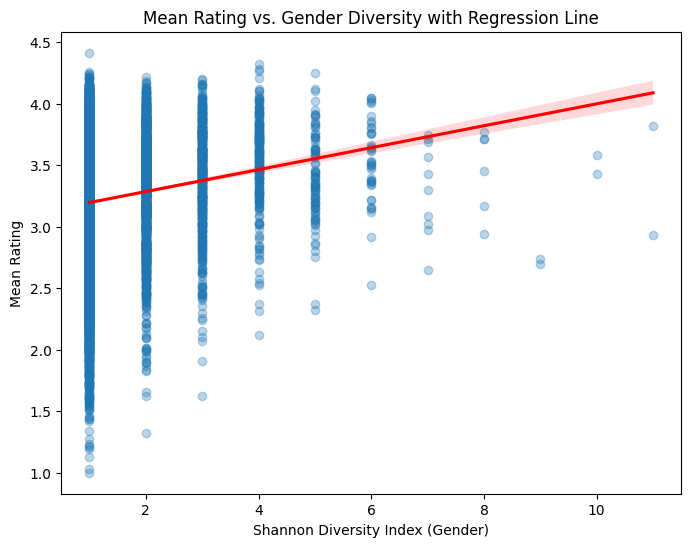

In [89]:
plt.figure(figsize=(8,6))
sns.regplot(
    x='nb_languages', 
    y='mean_rating', 
    data=df_correlation_languages, 
    scatter_kws={'alpha':0.3}, 
    line_kws={'color':'red'}
)
plt.xlabel('Shannon Diversity Index (Gender)')
plt.ylabel('Mean Rating')
plt.title('Mean Rating vs. Gender Diversity with Regression Line')
plt.show()